In [1]:
!pip install tensorflow==2.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 53.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempti

In [2]:
import os
import re
import cv2
import random
import numpy as np
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from keras.layers import ZeroPadding2D, Convolution2D, Reshape, Dense
from keras.layers import Input, Conv2D, Conv2DTranspose, ReLU, Activation, Layer, BatchNormalization, UpSampling2D, concatenate, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
WIDTH, HEIGHT = 256, 256
BATCH_SIZE = 32
lr = 1e-04
epochs = 100
image_size = [256,256]

In [4]:
model_path = "/kaggle/working/segnet_carlo.h5"
csv_path = "/kaggle/working/csvlogger.csv"

# Helping Function

In [5]:
#create folder for save augmented images
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
#get data
def read_data(path):
    images = sorted(glob(os.path.join(path, "CameraRGB/*")))
    masks = sorted(glob(os.path.join(path, "CameraSeg/*")))
    
    return images, masks

In [7]:
def show_images_with_masks(image_dir, mask_dir):
    #image_files = sorted(os.listdir(image_dir))
    #mask_files = sorted(os.listdir(mask_dir))

    # Ensure equal number of images and masks
    num_files = min(len(image_dir), len(image_dir))

    # Display 5 images and masks
    num_display = min(num_files, 5)
    fig, axs = plt.subplots(num_display, 2, figsize=(10, 10))

    for i in range(num_display):

        image = cv2.imread(image_dir[i])
        mask = cv2.imread(mask_dir[i])[:,:,2]

        # Display image
        axs[i, 0].imshow(image)
        axs[i, 0].axis('off')
        axs[i, 0].set_title('Image')

        # Display mask
        axs[i, 1].imshow(mask)
        axs[i, 1].axis('off')
        axs[i, 1].set_title('Mask')

    plt.tight_layout()
    plt.show()

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_filenames, mask_filenames, batch_size=BATCH_SIZE, shuffle=True):
        self.img_filenames = img_filenames
        self.mask_filenames = mask_filenames
        self.filenames = list(zip(img_filenames, mask_filenames))
        self.batch_size = BATCH_SIZE
        self.shuffle= shuffle
        self.n = len(self.img_filenames)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)

    def __get_data(self, batches):
        imgs=[]
        segs=[]
        for img_file, mask_file in batches:
            image = cv2.imread(img_file)
            image = cv2.resize(image, (WIDTH, HEIGHT))
            image = image / 255.
            
            mask = cv2.imread(mask_file)
            mask = cv2.resize(mask, (WIDTH, HEIGHT))[:, :, 2]

            imgs.append(image)
            segs.append(mask)

        return np.array(imgs), np.array(segs)
    
    def __getitem__(self, index):

        batches = self.filenames[index * self.batch_size:(index + 1) * self.batch_size]

        X, y = self.__get_data(batches)

        return (X, y)

    def __len__(self):

        return self.n // self.batch_size   

In [9]:
#set color to image
def give_color_to_seg_img(seg, n_classes=13):
    seg_img = np.zeros( (seg.shape[0],seg.shape[1], 3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

# Data Preprocessing

In [10]:
path_1 = "/kaggle/input/lyft-udacity-challenge/dataA/dataA"
path_2 = "/kaggle/input/lyft-udacity-challenge/dataB/dataB/"
images_1, masks_1 = read_data(path_1)
images_2, masks_2 = read_data(path_2)

In [11]:
images = images_1 + images_2
masks = masks_1 + masks_2

In [12]:
test_path = "/kaggle/input/lyft-udacity-challenge/dataC/dataC"
test_images, test_masks = read_data(test_path)

In [13]:
train_gen = DataGenerator(images_1, masks_1)
test_gen = DataGenerator(test_images[0:700], test_masks[0:700])

In [14]:
#train data shape
for x, y in train_gen:
    break
x.shape, y.shape

((32, 256, 256, 3), (32, 256, 256))

In [15]:
#test data shape
for x, y in test_gen:
    break
x.shape, y.shape

((32, 256, 256, 3), (32, 256, 256))

(-0.5, 255.5, 255.5, -0.5)

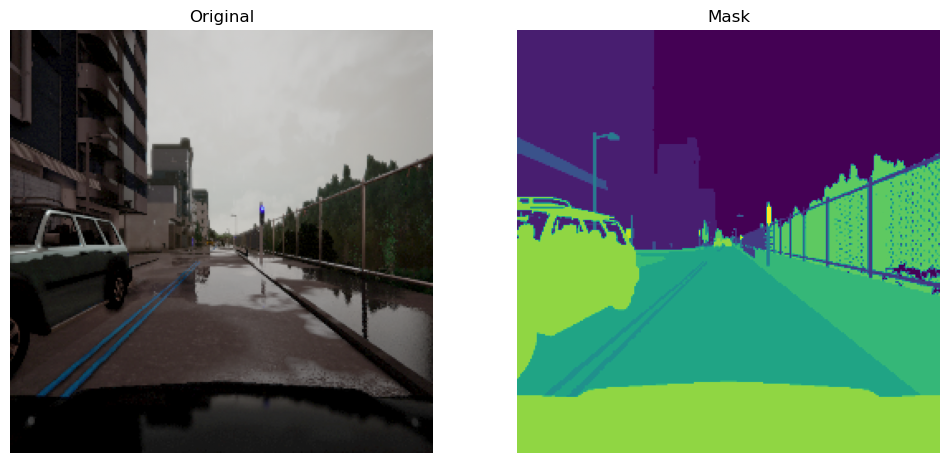

In [16]:
#visualize image and mask
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(x[0])
plt.title('Original')
plt.axis('off')

plt.subplot(122)
plt.imshow(y[0])
plt.title('Mask')
plt.axis('off')

# Model - SegNet

In [17]:
def build_model():
    inputs = Input(shape=(256, 256, 3))
    
    c1 = Conv2D(64, (3,3), padding='same', strides=(1,1), kernel_initializer='he_normal')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = ReLU()(c1)
    c1 = MaxPooling2D((2, 2), strides=(2, 2))(c1)
    
    c2 = Conv2D(128, (3,3), padding='same', strides=(1,1), kernel_initializer='he_normal')(c1)
    c2 = BatchNormalization()(c2)
    c2 = ReLU()(c2)
    c2 = MaxPooling2D((2, 2), strides=(2, 2))(c2)
    
    c3 = Conv2D(256, (3,3), padding='same', strides=(1,1), kernel_initializer='he_normal')(c2)
    c3 = BatchNormalization()(c3)
    c3 = ReLU()(c3)
    c3 = MaxPooling2D((2, 2), strides=(2, 2))(c3)
    
    c4 = Conv2D(512, (3,3), padding='same', strides=(1,1), kernel_initializer='he_normal')(c3)
    c4 = BatchNormalization()(c4)
    c4 = ReLU()(c4)
    c4 = MaxPooling2D((2, 2), strides=(2, 2))(c4)
    
    #Decoder
    u4 = UpSampling2D(interpolation='bilinear')(c4)
    u4 = Conv2D(512, (3,3), padding='same', strides=(1,1), kernel_initializer='he_normal')(u4)
    u4 = BatchNormalization()(u4)
    u4 = ReLU()(u4)
    
    u3 = UpSampling2D(interpolation='bilinear')(u4)
    u3 = Conv2D(256, (3,3), padding='same', strides=(1,1), kernel_initializer='he_normal')(u3)
    u3 = BatchNormalization()(u3)
    u3 = ReLU()(u3)
    
    u2 = UpSampling2D(interpolation='bilinear')(u3)
    u2 = Conv2D(128, (3,3), padding='same', strides=(1,1), kernel_initializer='he_normal')(u2)
    u2 = BatchNormalization()(u2)
    u2 = ReLU()(u2)
    
    u1 = UpSampling2D(interpolation='bilinear')(u2)
    u1 = Conv2D(64, (3,3), padding='same', strides=(1,1), kernel_initializer='he_normal')(u1)
    u1 = BatchNormalization()(u1)
    u1 = ReLU()(u1)
    
    #dense = Dense(32, activation='relu')
    x = Conv2D(13, (1,1), name="output_layer")(u1)
    x = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model
    

In [18]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 64)     256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 256, 256, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856 

In [19]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])

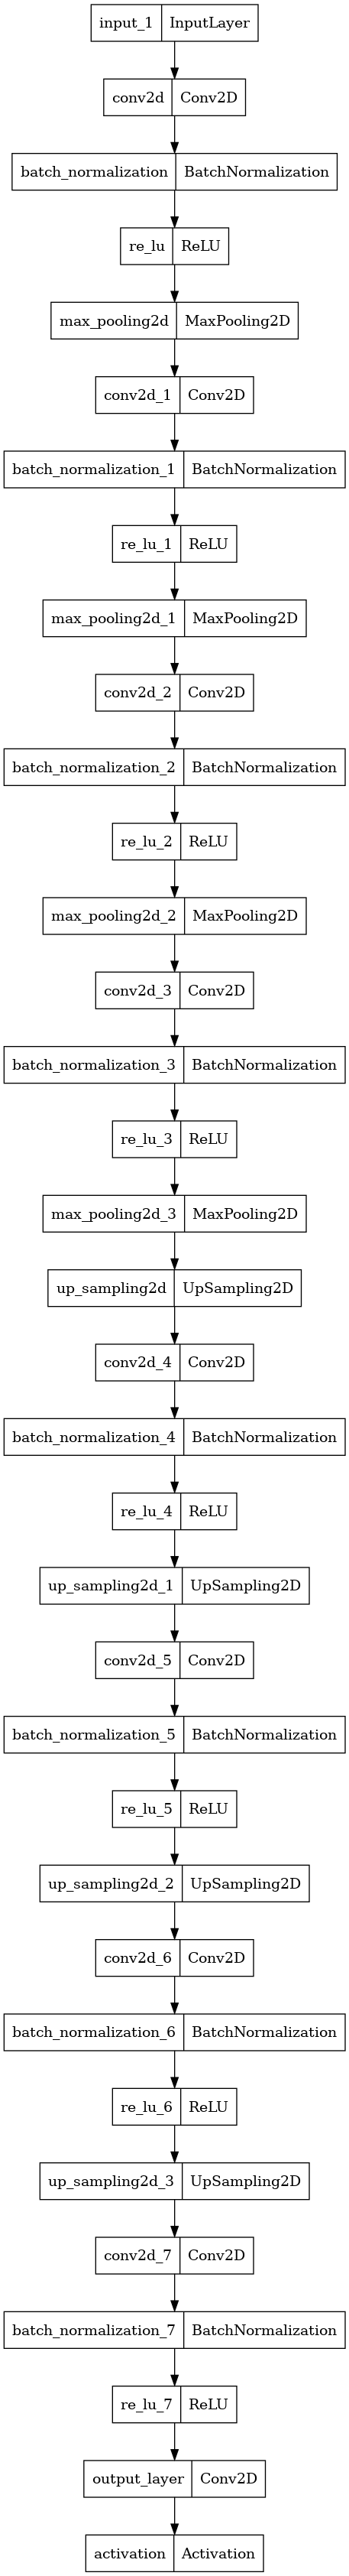

In [20]:
from keras.utils import plot_model
plot_model(model, to_file="/kaggle/working/model.png")

In [21]:
#learning rate
def lrfn(epoch):
    if epoch > 20:
        return 2e-1
    elif epoch > 40:
        return 1e-5
    return 1e-5

In [22]:
#Callbacks
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: lrfn(step))
Callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True), 
    CSVLogger(csv_path),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)
]

# Training

In [23]:
train_steps = len(train_gen)
val_steps = len(test_gen)

history = model.fit(train_gen, validation_data=test_gen, 
                    steps_per_epoch=train_steps, validation_steps=val_steps, 
                    epochs = 30, verbose=1, callbacks=Callbacks)

Epoch 1/30
31/31 [==============================] - ETA: 0s - loss: 1.2598 - accuracy: 0.6746
Epoch 1: val_loss improved from inf to 2.15284, saving model to /kaggle/working/segnet_carlo.h5
31/31 [==============================] - 69s 2s/step - loss: 1.2598 - accuracy: 0.6746 - val_loss: 2.1528 - val_accuracy: 0.4357 - lr: 1.0000e-04
Epoch 2/30
31/31 [==============================] - ETA: 0s - loss: 0.7816 - accuracy: 0.8056
Epoch 2: val_loss improved from 2.15284 to 1.81167, saving model to /kaggle/working/segnet_carlo.h5
31/31 [==============================] - 42s 1s/step - loss: 0.7816 - accuracy: 0.8056 - val_loss: 1.8117 - val_accuracy: 0.5287 - lr: 1.0000e-04
Epoch 3/30
31/31 [==============================] - ETA: 0s - loss: 0.6293 - accuracy: 0.8439
Epoch 3: val_loss improved from 1.81167 to 1.64627, saving model to /kaggle/working/segnet_carlo.h5
31/31 [==============================] - 42s 1s/step - loss: 0.6293 - accuracy: 0.8439 - val_loss: 1.6463 - val_accuracy: 0.5435 -

# Model's Performance

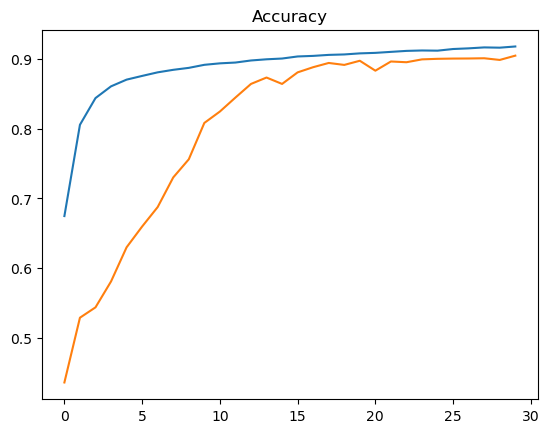

In [24]:
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.show()

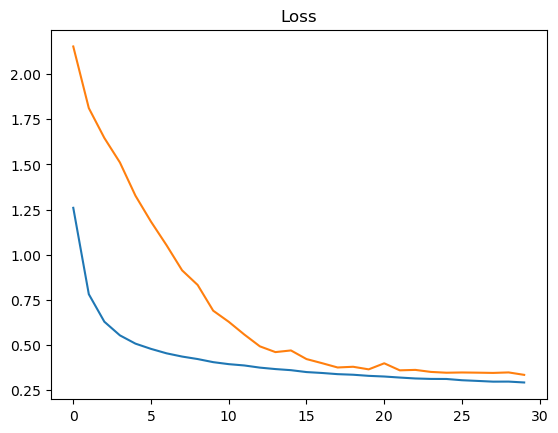

In [25]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.show()

# Predictions

In [26]:
create_dir("/kaggle/working/predicted")

1/1 [==============================] - 0s 250ms/step


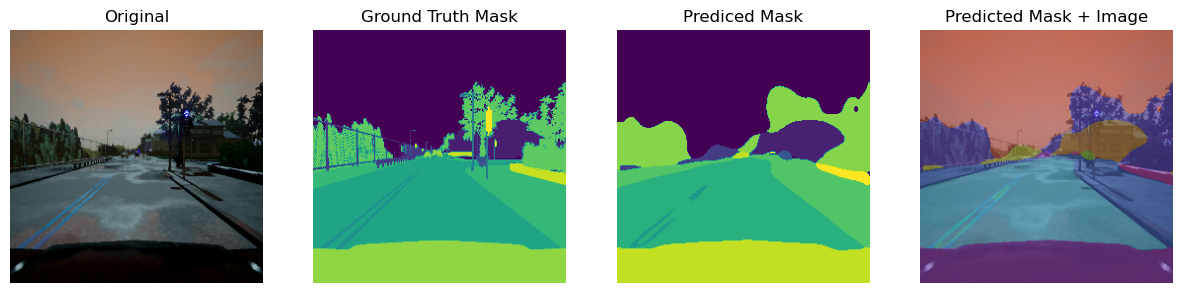

1/1 [==============================] - 0s 34ms/step


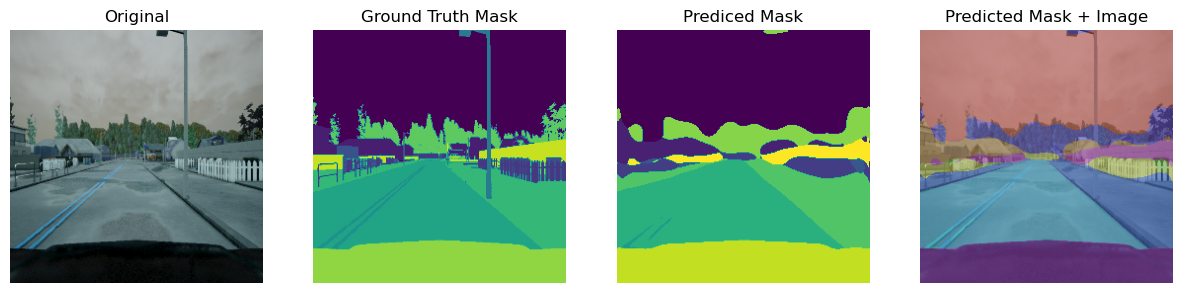

1/1 [==============================] - 0s 33ms/step


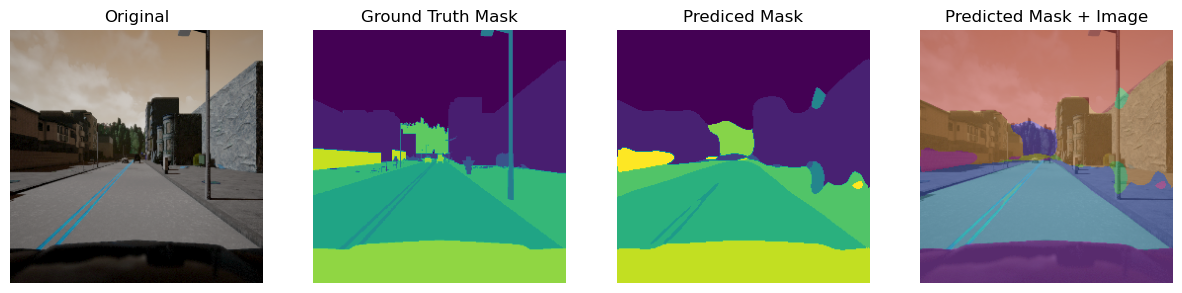

1/1 [==============================] - 0s 32ms/step


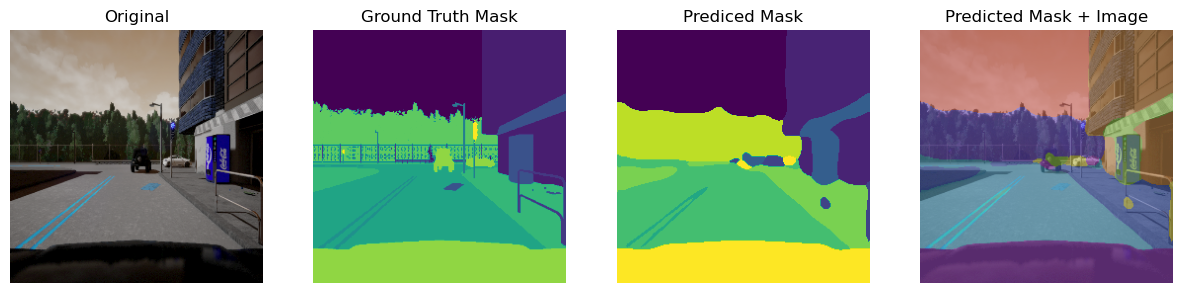

1/1 [==============================] - 0s 33ms/step


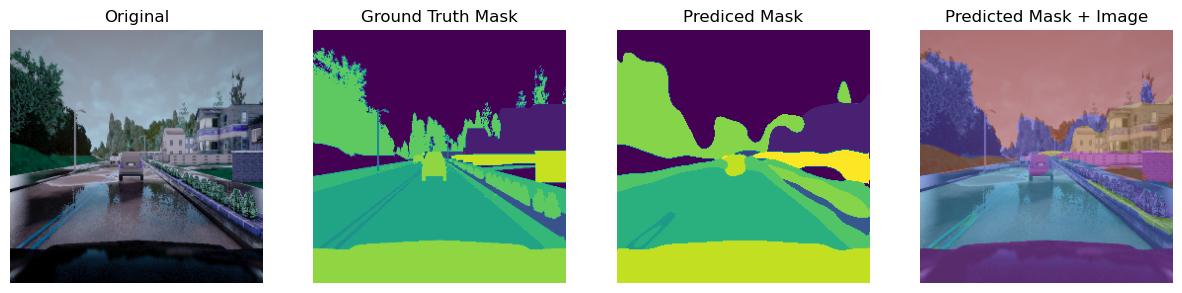

1/1 [==============================] - 0s 32ms/step


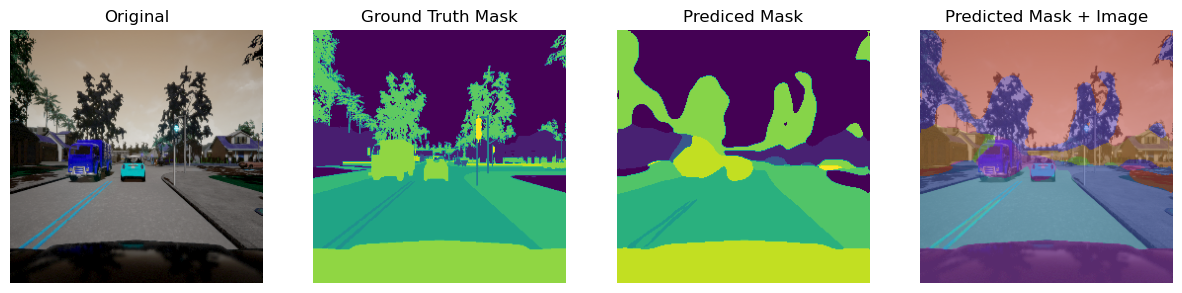

1/1 [==============================] - 0s 32ms/step


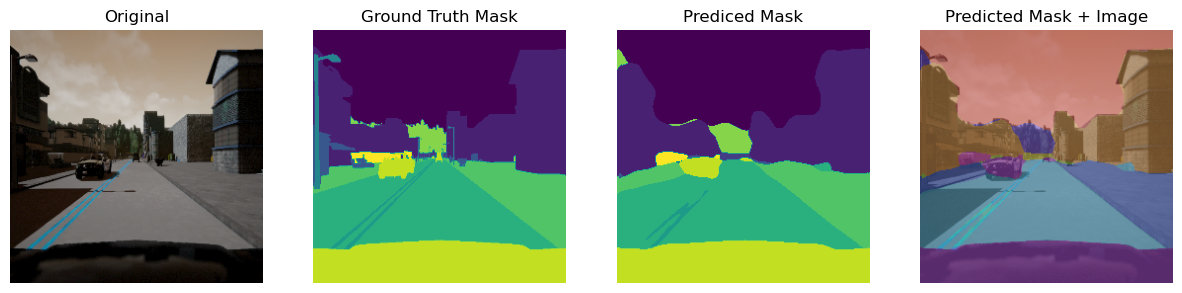

1/1 [==============================] - 0s 32ms/step


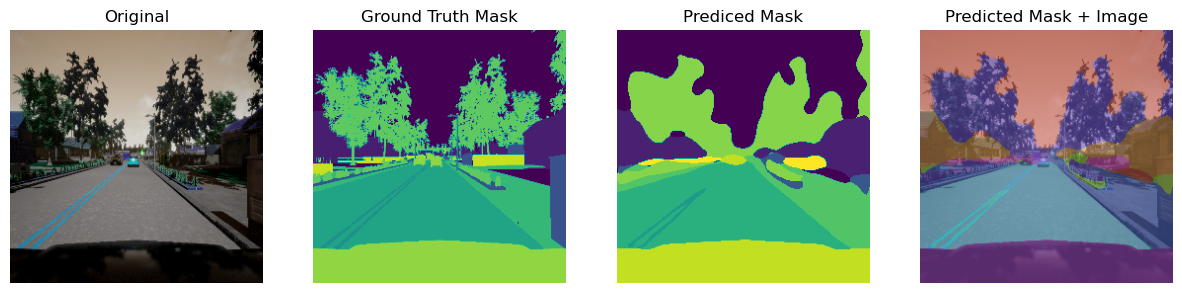

1/1 [==============================] - 0s 32ms/step


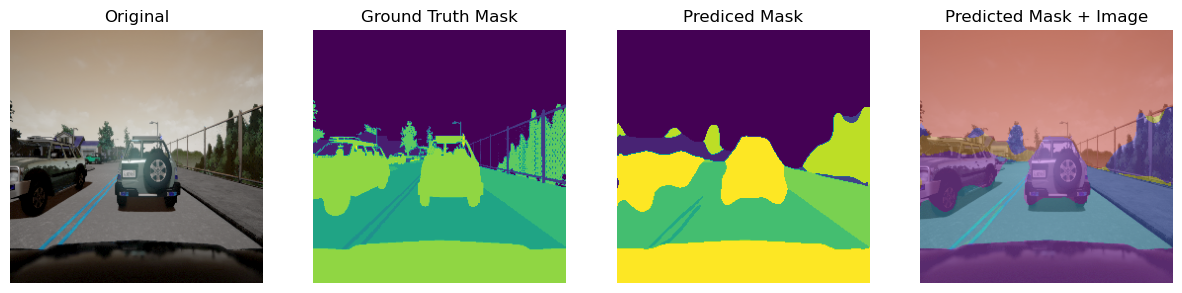

1/1 [==============================] - 0s 32ms/step


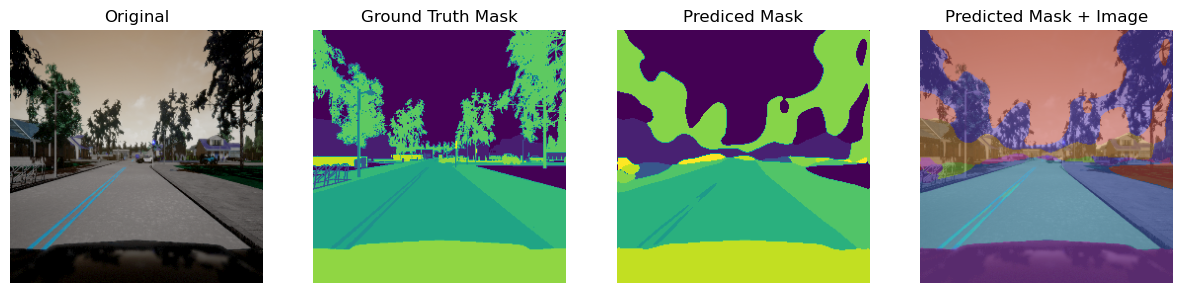

1/1 [==============================] - 0s 35ms/step


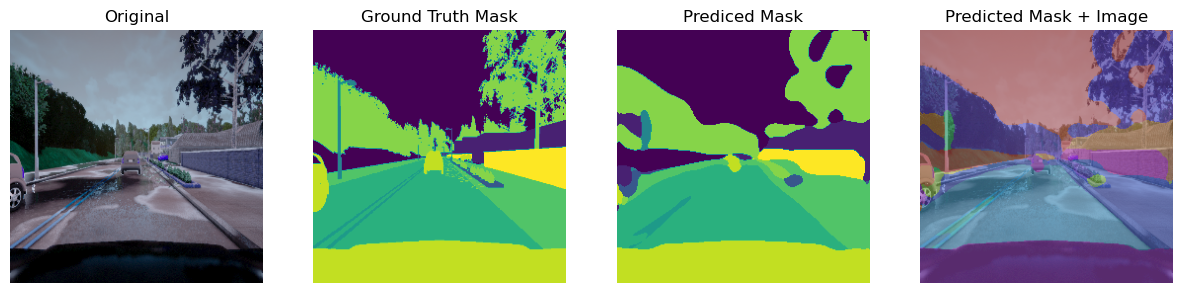

1/1 [==============================] - 0s 33ms/step


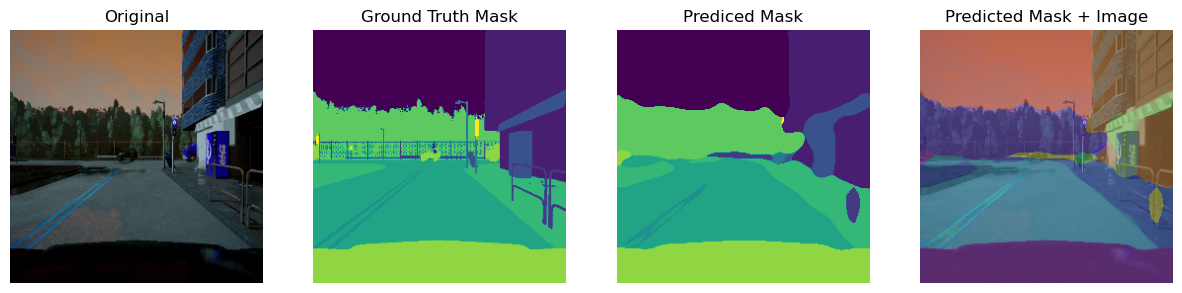

In [27]:
#prediction
max_show = 12
test_iter = iter(test_gen)
for i in range(max_show):
    images, masks = next(test_iter)
    mask_color = give_color_to_seg_img(masks[0])

    preds = model.predict(images)
    pred_masks = np.argmax(preds, axis = 3)
    pred_mask_color = give_color_to_seg_img(pred_masks[0])
    fig, ax = plt.subplots(1, 4, figsize=(15, 6))
    
    for a in ax:
        a.axis('off')

    ax[0].imshow(images[0])
    ax[0].set_title('Original')
    
    ax[1].imshow(masks[0])
    ax[1].set_title('Ground Truth Mask')
    
    ax[2].imshow(pred_masks[0])
    ax[2].set_title('Prediced Mask')
    
    ax[3].imshow(images[0] * 0.5 + pred_mask_color * 0.5)
    ax[3].set_title('Predicted Mask + Image')
    plt.savefig(f"predicted/pred_{i}.jpg", dpi=150)
    plt.show()